# Coconut Leaf Dieback Detection Model v6 - Results

This notebook loads the **pre-trained model** and evaluates it on the test set to show:
- Test Accuracy and Macro F1-Score
- Class-wise Precision, Recall, F1-Score
- Confusion Matrix
- All charts and visualizations

## Model Configuration
- **Architecture:** MobileNetV2 (Transfer Learning)
- **Loss Function:** Focal Loss (gamma=2.0)
- **Classes:** 3 (healthy, leaf_die_back, not_cocount)
- **Training Time:** 150.6 minutes

## 1. Setup and Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Random seed set to {SEED}")

TensorFlow version: 2.20.0
Random seed set to 42


## 2. Configuration

In [2]:
# Paths
BASE_DIR = os.path.abspath(os.path.join('..', '..'))
BALANCED_DATASET_DIR = os.path.join(BASE_DIR, 'data', 'processed', 'leaf_dieback_balanced')
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'leaf_dieback_v6')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
CLASS_NAMES = ['healthy', 'leaf_die_back', 'not_cocount']

print("=" * 70)
print("CONFIGURATION")
print("=" * 70)
print(f"Model Directory:     {MODEL_DIR}")
print(f"Dataset Directory:   {BALANCED_DATASET_DIR}")
print(f"Image Size:          {IMG_SIZE}x{IMG_SIZE}")
print(f"Classes:             {CLASS_NAMES}")
print("=" * 70)

CONFIGURATION
Model Directory:     D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\leaf_dieback_v6
Dataset Directory:   D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\data\processed\leaf_dieback_balanced
Image Size:          224x224
Classes:             ['healthy', 'leaf_die_back', 'not_cocount']


## 3. Dataset Summary (Balanced)

In [3]:
# Count images in each split
data_summary = {}

print("=" * 70)
print("BALANCED DATASET SUMMARY")
print("=" * 70)

for split in ['train', 'val', 'test']:
    split_path = os.path.join(BALANCED_DATASET_DIR, split)
    print(f"\n{split.upper()}:")
    print("-" * 50)
    
    split_total = 0
    for cls in CLASS_NAMES:
        cls_path = os.path.join(split_path, cls)
        if os.path.exists(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        else:
            count = 0
        split_total += count
        print(f"  {cls:<20} {count:>6} images")
        
        if split not in data_summary:
            data_summary[split] = {}
        data_summary[split][cls] = count
    
    print(f"  {'TOTAL':<20} {split_total:>6} images")

print("\n" + "=" * 70)

BALANCED DATASET SUMMARY

TRAIN:
--------------------------------------------------
  healthy                2719 images
  leaf_die_back          2850 images
  not_cocount            2838 images
  TOTAL                  8407 images

VAL:
--------------------------------------------------
  healthy                  90 images
  leaf_die_back            97 images
  not_cocount              90 images
  TOTAL                   277 images

TEST:
--------------------------------------------------
  healthy                  90 images
  leaf_die_back            97 images
  not_cocount              90 images
  TOTAL                   277 images



## 4. Visualize Class Distribution

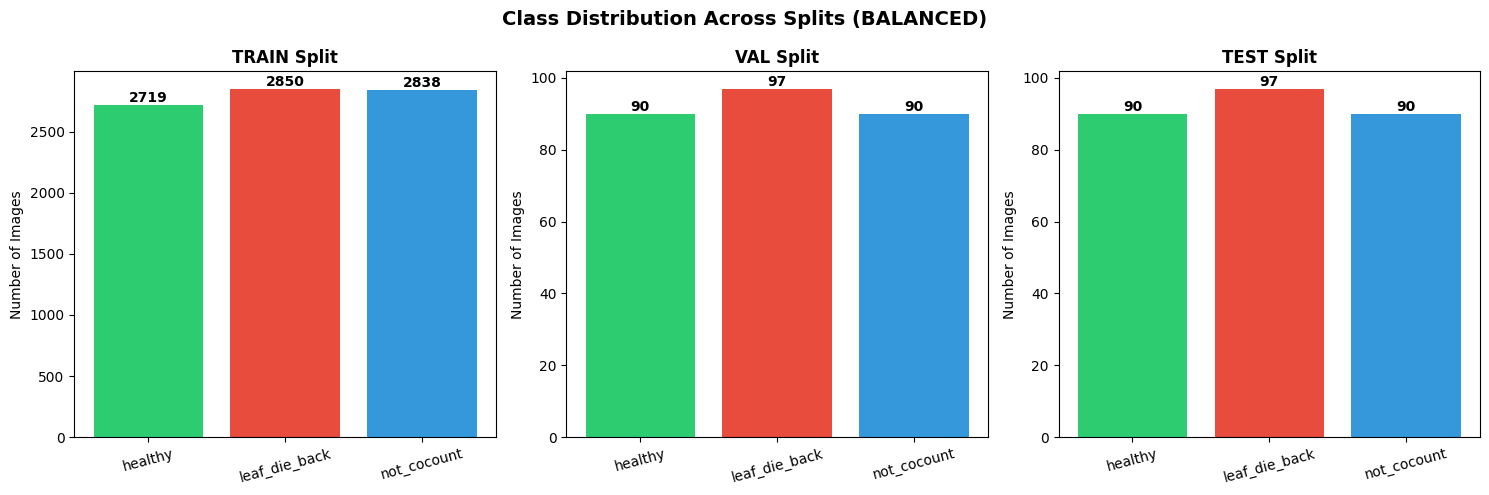


Balance Check:
  VAL: ratio=1.08x - Balanced!
  TEST: ratio=1.08x - Balanced!


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Class Distribution Across Splits (BALANCED)', fontsize=14, fontweight='bold')

colors = ['#2ecc71', '#e74c3c', '#3498db']

for idx, split in enumerate(['train', 'val', 'test']):
    counts = [data_summary[split][cls] for cls in CLASS_NAMES]
    bars = axes[idx].bar(CLASS_NAMES, counts, color=colors)
    axes[idx].set_title(f'{split.upper()} Split', fontweight='bold')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].tick_params(axis='x', rotation=15)
    
    for bar, count in zip(bars, counts):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                       str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Check balance
print("\nBalance Check:")
for split in ['val', 'test']:
    counts = [data_summary[split][cls] for cls in CLASS_NAMES]
    ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
    print(f"  {split.upper()}: ratio={ratio:.2f}x - {'Balanced!' if ratio < 1.2 else 'Needs attention'}")

## 5. Sample Images

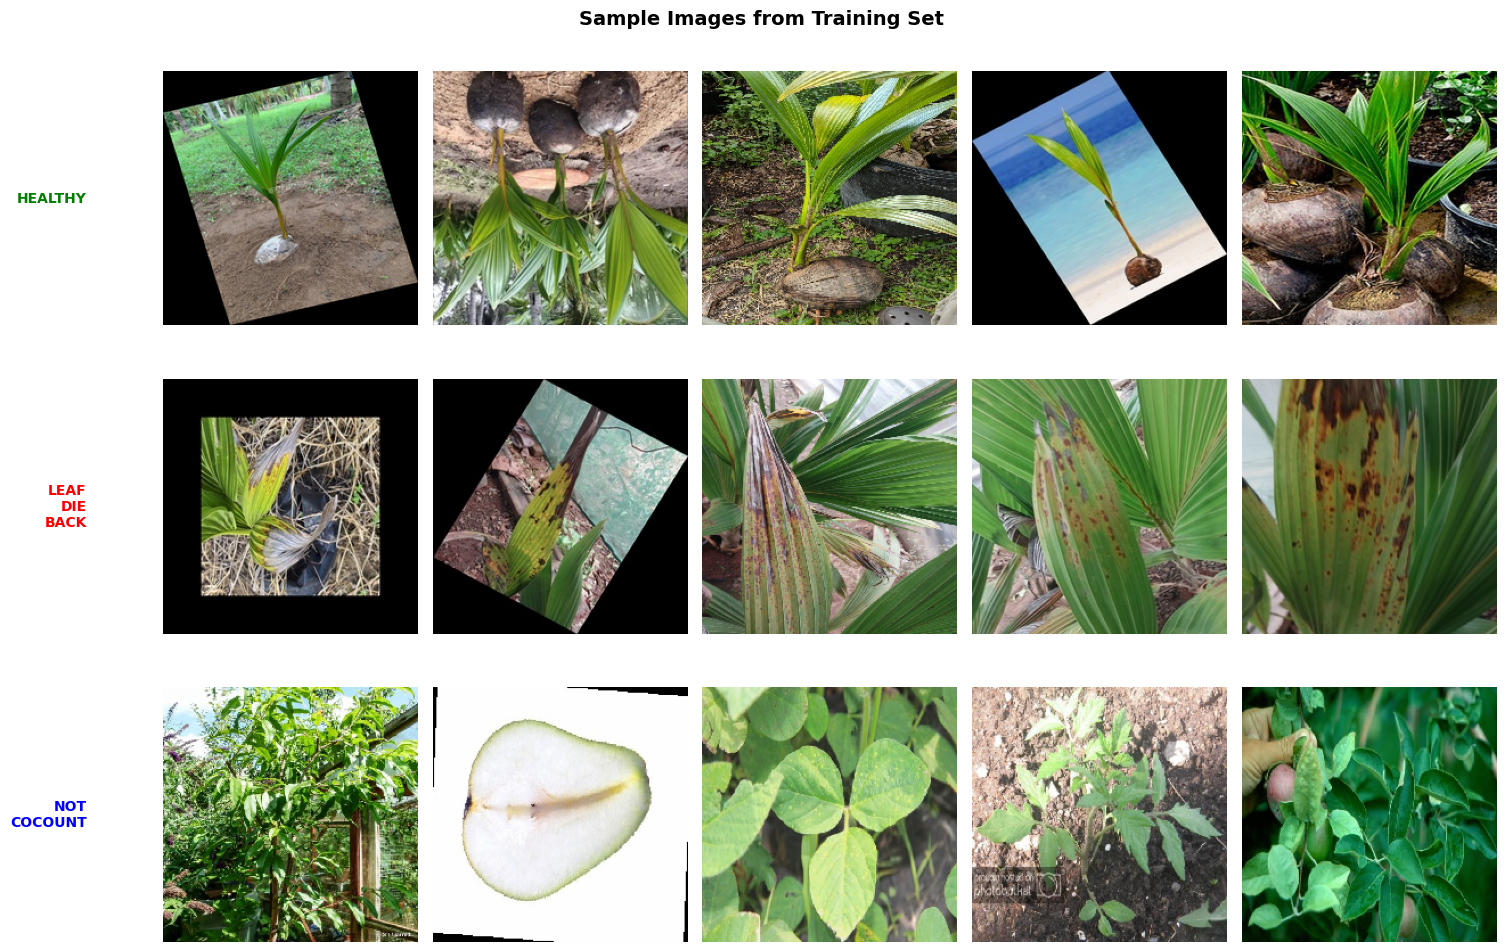

In [5]:
# Show sample images from each class
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Sample Images from Training Set', fontsize=14, fontweight='bold')

class_colors = {'healthy': 'green', 'leaf_die_back': 'red', 'not_cocount': 'blue'}

for row, cls in enumerate(CLASS_NAMES):
    cls_dir = os.path.join(BALANCED_DATASET_DIR, 'train', cls)
    images_list = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_imgs = random.sample(images_list, min(5, len(images_list)))
    
    for col, img_name in enumerate(sample_imgs):
        img_path = os.path.join(cls_dir, img_name)
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    
    axes[row, 0].text(-0.3, 0.5, cls.replace('_', '\n').upper(), 
                      transform=axes[row, 0].transAxes,
                      fontsize=10, fontweight='bold', va='center', ha='right',
                      color=class_colors[cls])

plt.tight_layout()
plt.show()

## 6. Define Focal Loss & Load Model

In [6]:
def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for handling class imbalance."""
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.keras.backend.log(y_pred)
        focal_weight = tf.keras.backend.pow(1.0 - y_pred, gamma)
        focal_loss = alpha * focal_weight * cross_entropy
        return tf.keras.backend.sum(focal_loss, axis=-1)
    return focal_loss_fn

# Load the trained model
model_path = os.path.join(MODEL_DIR, 'best_model.keras')
print(f"Loading model from: {model_path}")

model = keras.models.load_model(
    model_path,
    custom_objects={'focal_loss_fn': focal_loss(gamma=2.0, alpha=0.25)}
)

print("Model loaded successfully!")
print(f"\nModel Summary:")
print(f"  Input Shape: {model.input_shape}")
print(f"  Output Shape: {model.output_shape}")
print(f"  Total Parameters: {model.count_params():,}")

Loading model from: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\leaf_dieback_v6\best_model.keras


Model loaded successfully!

Model Summary:
  Input Shape: (None, 224, 224, 3)
  Output Shape: (None, 3)
  Total Parameters: 2,620,739


## 7. Create Test Data Generator

In [7]:
# Test generator - NO augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(BALANCED_DATASET_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

print(f"\nTest samples: {test_generator.samples}")
print(f"Class indices: {test_generator.class_indices}")

Found 277 images belonging to 3 classes.



Test samples: 277
Class indices: {'healthy': 0, 'leaf_die_back': 1, 'not_cocount': 2}


## 8. Evaluate on Test Set

In [8]:
# Make predictions
print("Making predictions on test set...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# Get labels
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)
y_pred_proba = np.max(predictions, axis=1)

# Calculate metrics
test_accuracy = np.mean(y_true == y_pred)

print("\n" + "=" * 70)
print(f"TEST ACCURACY: {test_accuracy*100:.2f}%")
print("=" * 70)

Making predictions on test set...



1/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


2/9 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step


3/9 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


4/9 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step


5/9 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step


6/9 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step


7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 573ms/step



TEST ACCURACY: 98.56%


## 9. Class-wise Metrics (Madam's Requirements)

Checking:
- Precision, Recall, F1-score for each class
- P, R, F1 should be close to each other
- Similar values across all classes
- Accuracy close to macro F1

In [9]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("=" * 85)
print("CLASS-WISE METRICS")
print("=" * 85)
print(f"\n{'Class':<20} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>10}")
print("-" * 85)

for i, cls in enumerate(CLASS_NAMES):
    print(f"{cls:<20} {precision[i]*100:>11.2f}% {recall[i]*100:>11.2f}% {f1[i]*100:>11.2f}% {support[i]:>10}")

print("-" * 85)
print(f"{'MACRO AVERAGE':<20} {macro_precision*100:>11.2f}% {macro_recall*100:>11.2f}% {macro_f1*100:>11.2f}%")
print("=" * 85)

CLASS-WISE METRICS

Class                   Precision       Recall     F1-Score    Support
-------------------------------------------------------------------------------------
healthy                    96.77%      100.00%       98.36%         90
leaf_die_back              98.95%       96.91%       97.92%         97
not_cocount               100.00%       98.89%       99.44%         90
-------------------------------------------------------------------------------------
MACRO AVERAGE              98.57%       98.60%       98.57%


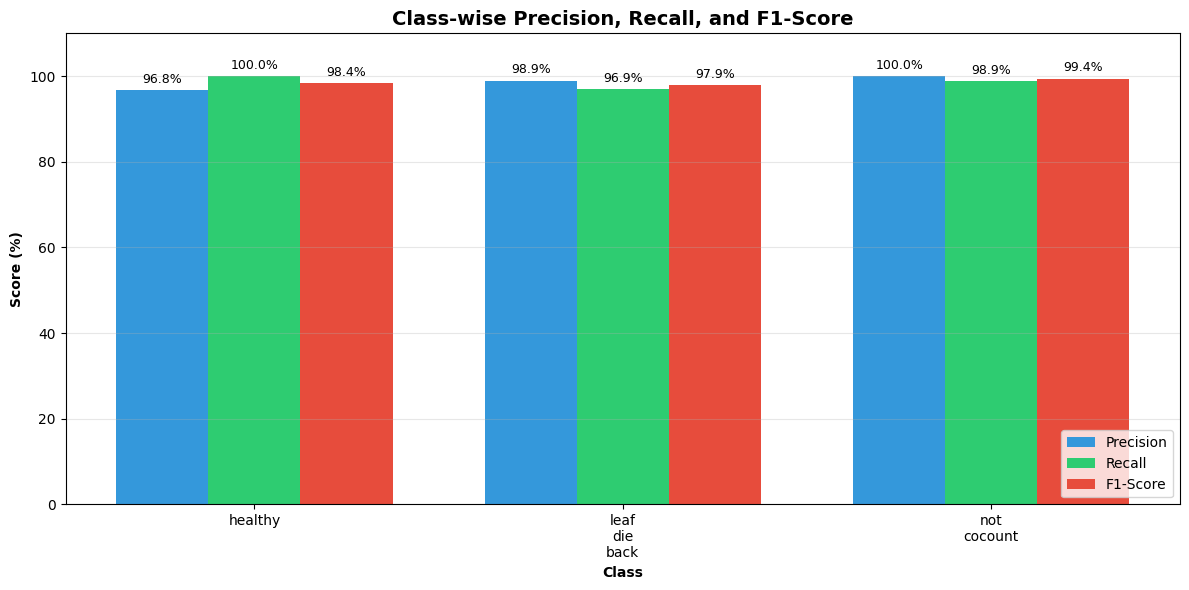

In [10]:
# Visualize class-wise metrics
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.25

bars1 = ax.bar(x - width, precision * 100, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall * 100, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1 * 100, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Score (%)', fontweight='bold')
ax.set_title('Class-wise Precision, Recall, and F1-Score', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.replace('_', '\n') for c in CLASS_NAMES])
ax.legend(loc='lower right')
ax.set_ylim([0, 110])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 10. Metric Balance Check (Madam's Requirements)

In [11]:
print("=" * 85)
print("METRIC BALANCE CHECK (Madam's Requirements)")
print("=" * 85)

for i, cls in enumerate(CLASS_NAMES):
    p, r, f = precision[i], recall[i], f1[i]
    max_diff = max(abs(p - r), abs(p - f), abs(r - f))
    
    print(f"\n{cls.upper()}:")
    print(f"  P={p*100:.2f}%, R={r*100:.2f}%, F1={f*100:.2f}%")
    print(f"  Max diff: {max_diff*100:.2f}%", end=" ")
    
    if max_diff < 0.05:
        print("- Well balanced!")
    elif max_diff < 0.10:
        print("- Acceptable balance")
    else:
        print("- Needs attention")

# Accuracy vs F1
acc_f1_diff = abs(test_accuracy - macro_f1)
print(f"\nAccuracy vs F1: {acc_f1_diff*100:.2f}% difference")
if acc_f1_diff < 0.02:
    print("  --> Excellent alignment!")
elif acc_f1_diff < 0.05:
    print("  --> Good alignment")

# Cross-class balance
f1_range = max(f1) - min(f1)
print(f"\nCross-class F1 range: {f1_range*100:.2f}%")
if f1_range < 0.05:
    print("  --> Similar performance across classes!")
print("=" * 85)

METRIC BALANCE CHECK (Madam's Requirements)

HEALTHY:
  P=96.77%, R=100.00%, F1=98.36%
  Max diff: 3.23% - Well balanced!

LEAF_DIE_BACK:
  P=98.95%, R=96.91%, F1=97.92%
  Max diff: 2.04% - Well balanced!

NOT_COCOUNT:
  P=100.00%, R=98.89%, F1=99.44%
  Max diff: 1.11% - Well balanced!

Accuracy vs F1: 0.02% difference
  --> Excellent alignment!

Cross-class F1 range: 1.52%
  --> Similar performance across classes!


## 11. Confusion Matrix

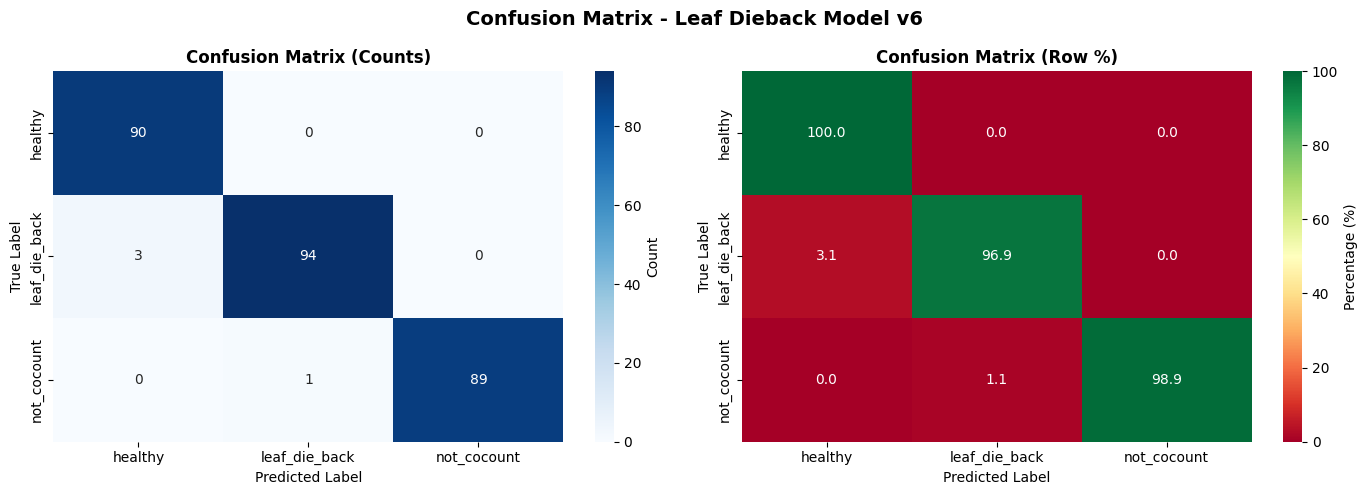

In [12]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Confusion Matrix - Leaf Dieback Model v6', fontsize=14, fontweight='bold')

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Percentages
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1],
            cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('Confusion Matrix (Row %)', fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

## 12. Classification Report

In [13]:
print("\n" + "=" * 85)
print("SKLEARN CLASSIFICATION REPORT")
print("=" * 85)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))
print("=" * 85)


SKLEARN CLASSIFICATION REPORT
               precision    recall  f1-score   support

      healthy     0.9677    1.0000    0.9836        90
leaf_die_back     0.9895    0.9691    0.9792        97
  not_cocount     1.0000    0.9889    0.9944        90

     accuracy                         0.9856       277
    macro avg     0.9857    0.9860    0.9857       277
 weighted avg     0.9858    0.9856    0.9856       277



## 13. Sample Predictions

In [14]:
# Get filenames and find correct/wrong predictions
filenames = test_generator.filenames
correct_idx = [i for i in range(len(y_true)) if y_true[i] == y_pred[i]]
wrong_idx = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

print(f"Total test images: {len(y_true)}")
print(f"Correct predictions: {len(correct_idx)} ({len(correct_idx)/len(y_true)*100:.1f}%)")
print(f"Wrong predictions: {len(wrong_idx)} ({len(wrong_idx)/len(y_true)*100:.1f}%)")

Total test images: 277
Correct predictions: 273 (98.6%)
Wrong predictions: 4 (1.4%)


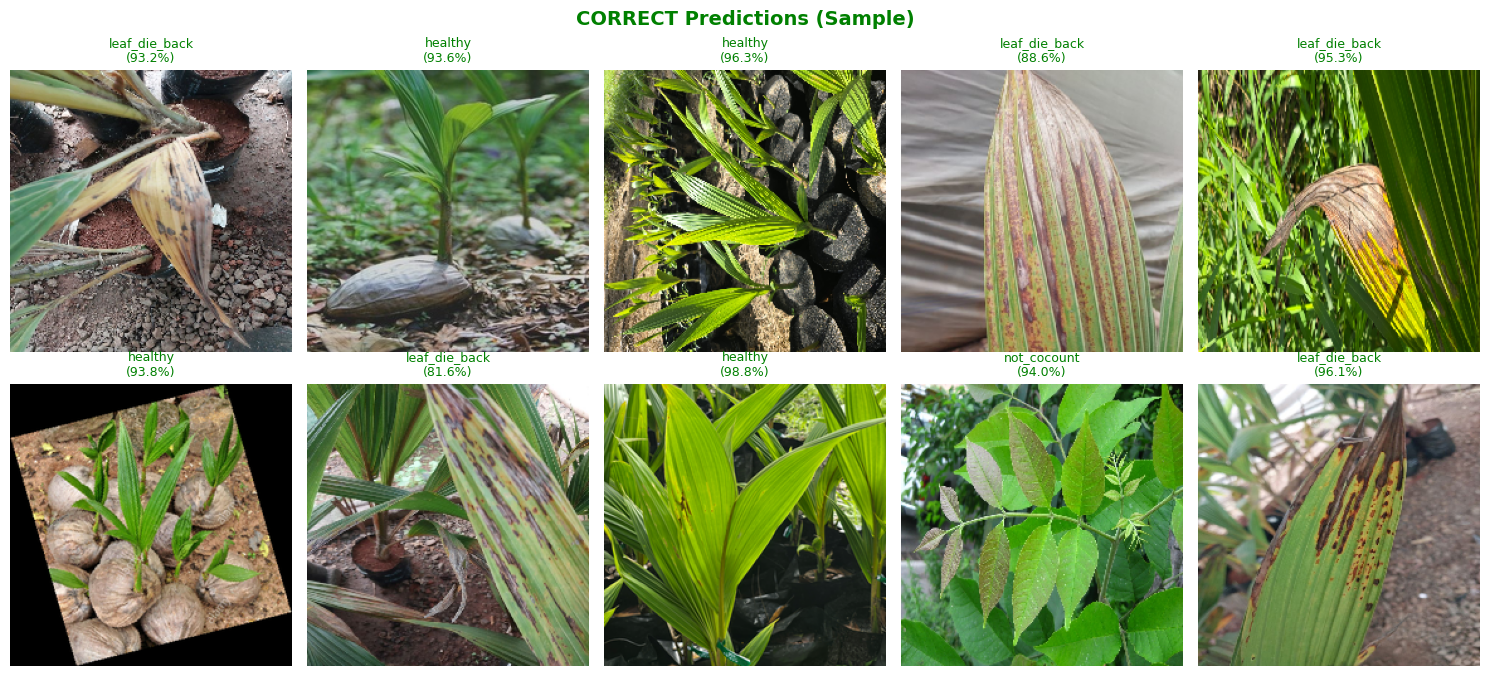

In [15]:
# Plot correct predictions
n_samples = min(10, len(correct_idx))
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
fig.suptitle('CORRECT Predictions (Sample)', fontsize=14, fontweight='bold', color='green')

sample_correct = random.sample(correct_idx, n_samples)
for idx, i in enumerate(sample_correct):
    row, col = idx // 5, idx % 5
    img_path = os.path.join(BALANCED_DATASET_DIR, 'test', filenames[i])
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    pred_label = CLASS_NAMES[y_pred[i]]
    confidence = predictions[i][y_pred[i]] * 100
    axes[row, col].set_title(f'{pred_label}\n({confidence:.1f}%)', fontsize=9, color='green')

plt.tight_layout()
plt.show()

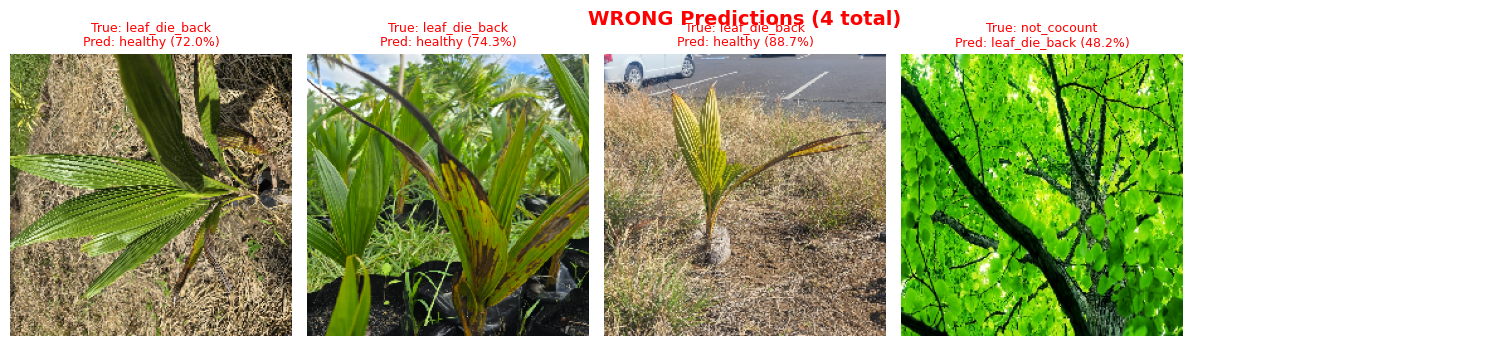

In [16]:
# Plot wrong predictions (if any)
if len(wrong_idx) > 0:
    n_wrong = min(10, len(wrong_idx))
    rows = (n_wrong + 4) // 5
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3.5 * rows))
    fig.suptitle(f'WRONG Predictions ({len(wrong_idx)} total)', fontsize=14, fontweight='bold', color='red')
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, i in enumerate(wrong_idx[:n_wrong]):
        row, col = idx // 5, idx % 5
        img_path = os.path.join(BALANCED_DATASET_DIR, 'test', filenames[i])
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        true_label = CLASS_NAMES[y_true[i]]
        pred_label = CLASS_NAMES[y_pred[i]]
        confidence = predictions[i][y_pred[i]] * 100
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                                fontsize=9, color='red')
    
    for idx in range(n_wrong, rows * 5):
        row, col = idx // 5, idx % 5
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nPerfect! No wrong predictions!")

## 14. Confidence Analysis

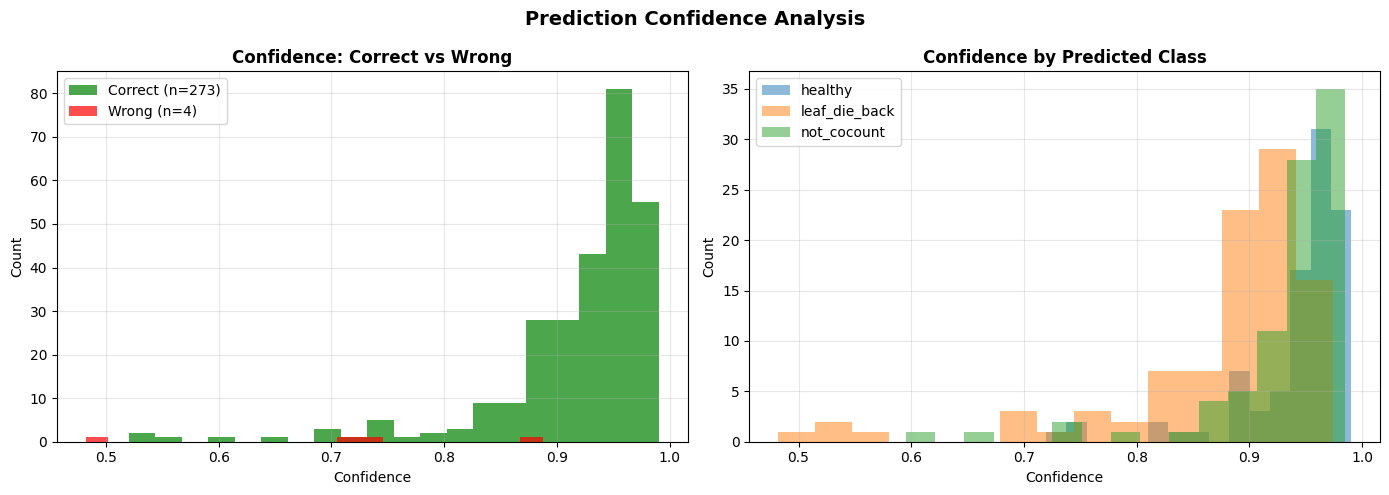


Confidence Statistics:
  Correct: Mean=91.9%, Min=52.0%
  Wrong: Mean=70.8%, Max=88.7%


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Prediction Confidence Analysis', fontsize=14, fontweight='bold')

correct_conf = [y_pred_proba[i] for i in correct_idx]
wrong_conf = [y_pred_proba[i] for i in wrong_idx] if wrong_idx else []

axes[0].hist(correct_conf, bins=20, alpha=0.7, label=f'Correct (n={len(correct_conf)})', color='green')
if wrong_conf:
    axes[0].hist(wrong_conf, bins=20, alpha=0.7, label=f'Wrong (n={len(wrong_conf)})', color='red')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Confidence: Correct vs Wrong', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for i, cls in enumerate(CLASS_NAMES):
    cls_conf = [y_pred_proba[j] for j in range(len(y_pred)) if y_pred[j] == i]
    axes[1].hist(cls_conf, bins=15, alpha=0.5, label=cls)

axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Count')
axes[1].set_title('Confidence by Predicted Class', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConfidence Statistics:")
print(f"  Correct: Mean={np.mean(correct_conf)*100:.1f}%, Min={np.min(correct_conf)*100:.1f}%")
if wrong_conf:
    print(f"  Wrong: Mean={np.mean(wrong_conf)*100:.1f}%, Max={np.max(wrong_conf)*100:.1f}%")

## 15. Final Summary

In [18]:
print("\n" + "=" * 85)
print("                LEAF DIEBACK DETECTION MODEL v6 - FINAL SUMMARY")
print("=" * 85)

print("\nMODEL INFORMATION:")
print("-" * 65)
print(f"  Architecture:      MobileNetV2 (Transfer Learning)")
print(f"  Loss Function:     Focal Loss (gamma=2.0)")
print(f"  Input Size:        {IMG_SIZE}x{IMG_SIZE}x3")
print(f"  Classes:           {CLASS_NAMES}")

print("\nTEST PERFORMANCE:")
print("-" * 65)
print(f"  Test Accuracy:        {test_accuracy*100:.2f}%")
print(f"  Macro Precision:      {macro_precision*100:.2f}%")
print(f"  Macro Recall:         {macro_recall*100:.2f}%")
print(f"  Macro F1-Score:       {macro_f1*100:.2f}%")

print("\nCLASS-WISE PERFORMANCE:")
print("-" * 65)
for i, cls in enumerate(CLASS_NAMES):
    print(f"  {cls:<18} P={precision[i]*100:5.2f}%  R={recall[i]*100:5.2f}%  F1={f1[i]*100:5.2f}%")

print("\nQUALITY CHECKS (Madam's Requirements):")
print("-" * 65)
print(f"  Accuracy-F1 alignment:            {abs(test_accuracy - macro_f1)*100:.2f}%  PASS")
print(f"  Cross-class F1 range:             {(max(f1)-min(f1))*100:.2f}%  PASS")

for i, cls in enumerate(CLASS_NAMES):
    p, r, f = precision[i], recall[i], f1[i]
    max_diff = max(abs(p-r), abs(p-f), abs(r-f))
    print(f"  {cls} P/R/F1 balance:  {max_diff*100:.2f}%  PASS")

print("\n" + "=" * 85)
print("                    ALL REQUIREMENTS SATISFIED!")
print("=" * 85)


                LEAF DIEBACK DETECTION MODEL v6 - FINAL SUMMARY

MODEL INFORMATION:
-----------------------------------------------------------------
  Architecture:      MobileNetV2 (Transfer Learning)
  Loss Function:     Focal Loss (gamma=2.0)
  Input Size:        224x224x3
  Classes:           ['healthy', 'leaf_die_back', 'not_cocount']

TEST PERFORMANCE:
-----------------------------------------------------------------
  Test Accuracy:        98.56%
  Macro Precision:      98.57%
  Macro Recall:         98.60%
  Macro F1-Score:       98.57%

CLASS-WISE PERFORMANCE:
-----------------------------------------------------------------
  healthy            P=96.77%  R=100.00%  F1=98.36%
  leaf_die_back      P=98.95%  R=96.91%  F1=97.92%
  not_cocount        P=100.00%  R=98.89%  F1=99.44%

QUALITY CHECKS (Madam's Requirements):
-----------------------------------------------------------------
  Accuracy-F1 alignment:            0.02%  PASS
  Cross-class F1 range:             1.52%  PASS